<a href="https://colab.research.google.com/github/jonas-tfo/signal-peptide-prediction-models/blob/main/4-state/4state_sp_classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification of sequences into SP or Non-SP using transformer embedding and Gradient Boosting (XGBoost)

#### Imports and dependancies

In [1]:
%pip install transformers
%pip install xgboost
import pandas as  pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, roc_auc_score
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#### Constants

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PBLRost/"
FASTA_PATH = os.path.join(DRIVE_PATH, "data/complete_set_unpartitioned.fasta")
MODEL = "Rostlab/prot_bert"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import BertTokenizer, T5EncoderModel
tokenizer = AutoTokenizer.from_pretrained(MODEL)
encoder = AutoModel.from_pretrained(MODEL).to(device)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

#### Embedding function using transformer

In [3]:
def get_prostt5_embeddings_batched(sequences, batch_size=8):
    embeddings = []
    formatted = [" ".join(list(seq)) for seq in sequences]  # ProstT5 expects space-separated AAs

    with torch.no_grad():
        for i in tqdm(range(0, len(formatted), batch_size)):
            batch_seqs = formatted[i:i+batch_size]
            encoded = tokenizer(batch_seqs, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
            # ProstT5: outputs.last_hidden_state shape = (batch, seq_len, hidden)
            batch_embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # average pooling
            embeddings.extend(batch_embs)

    return np.array(embeddings)

def get_protbert_embeddings_batched(sequences, batch_size=16):
    embeddings = []

    # space-separated amino acids (ProtBERT requirement)
    formatted = [" ".join(list(seq)) for seq in sequences]

    with torch.no_grad():
        for i in tqdm(range(0, len(formatted), batch_size)):
            batch_seqs = formatted[i:i+batch_size]
            encoded = tokenizer(batch_seqs, return_tensors="pt", padding=True, truncation=True, max_length=512)

            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
            batch_embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # average pooling
            embeddings.extend(batch_embs)

    return np.array(embeddings)

#### Data loading and prep (including embedding)

In [4]:
def load_and_prep_data(dataPath: str):
    records = []
    with open(dataPath, "r") as f:
        current_record = {}
        for line in f:
            if line.startswith(">"):
                if current_record:
                    records.append(current_record)
                header = line[1:].strip().split("|")
                if len(header) == 3:
                    current_record = {
                        "uniprot_ac": header[0],
                        "kingdom": header[1],
                        "type": header[2],
                        "sequence": ""
                    }
                else:
                    current_record = {}
            elif current_record:
                if not current_record.get("sequence"):
                    current_record["sequence"] = line.strip()
    if current_record:
        records.append(current_record)
    df_raw = pd.DataFrame(records)

    # drop na rows
    df_raw.dropna(subset=['sequence', 'type'], inplace=True)

    # Remove records with 'P' in sequence (if needed)
    df = df_raw[~df_raw["sequence"].str.contains("P")].copy()

    # 4-state labeling
    df["type"] = df["type"].replace({
        "NO_SP": "0",
        "LIPO": "1",
        "SP": "2",
        "TAT": "3",
        "TATLIPO": "3" # TAT and TATLIPO both have label T
    })

    # Separate classes
    df_class_0 = df[df["type"] == "0"]
    df_class_1 = df[df["type"] == "1"]
    df_class_2 = df[df["type"] == "2"]
    df_class_3 = df[df["type"] == "3"]

    # Oversample minority classes to match class 0 size
    n_samples_target = len(df_class_0)

    df_class_1_upsampled = resample(
        df_class_1,
        replace=True,
        n_samples=n_samples_target,
        random_state=42
    )
    df_class_2_upsampled = resample(
        df_class_2,
        replace=True,
        n_samples=n_samples_target,
        random_state=42
    )
    df_class_3_upsampled = resample(
        df_class_3,
        replace=True,
        n_samples=n_samples_target,
        random_state=42
    )

    # Concatenate and shuffle
    df_balanced = pd.concat([df_class_0, df_class_1_upsampled, df_class_2_upsampled, df_class_3_upsampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Total records after oversampling: {len(df_balanced)}")
    print("Class distribution after oversampling:")
    print(df_balanced["type"].value_counts())

    sequences = df_balanced["sequence"].tolist()
    labels = df_balanced["type"].astype(int).tolist()

    # get embeddings from bert
    finSeqs = get_protbert_embeddings_batched(sequences, batch_size=16)
    finLabels = np.array(labels)

    # each part
    train_seqs, test_seqs, train_types, test_types = train_test_split(
        finSeqs, finLabels, test_size=0.2, random_state=42, stratify=finLabels
    )

    print(f"Training set size: {len(train_seqs)}")
    print(f"Test set size: {len(test_seqs)}")

    return train_seqs, test_seqs, train_types, test_types

train_seqs, test_seqs, train_types, test_types = load_and_prep_data(FASTA_PATH)

Total records after oversampling: 3420
Class distribution after oversampling:
type
2    855
3    855
0    855
1    855
Name: count, dtype: int64



100%|██████████| 214/214 [00:58<00:00,  3.66it/s]

Training set size: 2736
Test set size: 684


#### Setup for hyperparam tuning

In [7]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define a simplified parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': stats.randint(100, 400), # Sample integers between 100 and 400
    'learning_rate': stats.uniform(0.01, 0.2), # Sample floats between 0.01 and 0.2
    'max_depth': stats.randint(3, 8), # Sample integers between 3 and 8
    'subsample': stats.uniform(0.7, 0.3), # Sample floats between 0.7 and 1.0
    'colsample_bytree': stats.uniform(0.7, 0.3), # Sample floats between 0.7 and 1.0
    'gamma': stats.uniform(0, 0.3) # Sample floats between 0 and 0.3
}

# grid 5-fold search for optimal params
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='hist', # Use histogram-based tree method for GPU
    device='cuda' # Explicitly set device to GPU
)

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings that are sampled. Adjust as needed.
    scoring='accuracy',
    cv=cv,
    n_jobs=-1, # Use all available cores
    random_state=42 # for reproducibility
)

random_search.fit(train_seqs, train_types)

print("Best hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

print("\nBest cross-validation score:")
print(random_search.best_score_)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:41:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters found by RandomizedSearchCV:
{'colsample_bytree': np.float64(0.7493967559428825), 'gamma': np.float64(0.1602268258126326), 'learning_rate': np.float64(0.10696599427179664), 'max_depth': 3, 'n_estimators': 333, 'subsample': np.float64(0.8012845514210883)}

Best cross-validation score:
0.9948851732742631


#### Model def and training

In [9]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='hist', # Use histogram-based tree method for GPU
    device='cuda', # Explicitly set device to GPU
    **random_search.best_params_  # Use the best params found by grid search
)

model.fit(train_seqs, train_types)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:58:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7493967559428825), device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=np.float64(0.1602268258126326), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.10696599427179664), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=333, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)


#### Model eval

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:58:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.993
Precision (weighted): 0.993
Recall (weighted): 0.993
F1 Score (weighted): 0.993
Matthews Correlation Coefficient: 0.99

Classification Report:
              precision    recall  f1-score   support

           0     0.9884    0.9942    0.9913       171
           1     0.9941    0.9883    0.9912       171
           2     0.9883    0.9883    0.9883       171
           3     1.0000    1.0000    1.0000       171

    accuracy                         0.9927       684
   macro avg     0.9927    0.9927    0.9927       684
weighted avg     0.9927    0.9927    0.9927       684



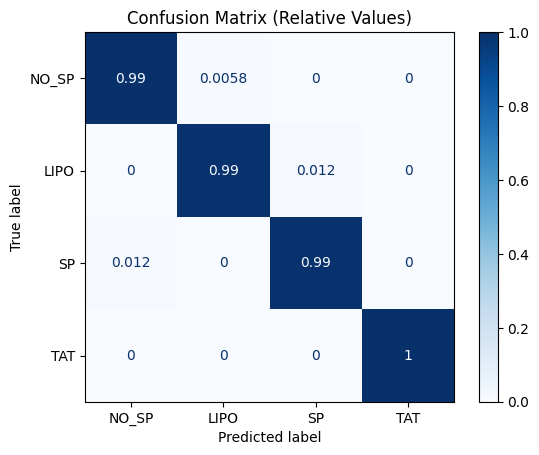

ROC AUC (macro): 1.0


In [10]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Predictions
pred_types = model.predict(test_seqs)

# Basic metrics
print("Accuracy:", round(accuracy_score(test_types, pred_types), 3))
print("Precision (weighted):", round(precision_score(test_types, pred_types, average='weighted'), 3))
print("Recall (weighted):", round(recall_score(test_types, pred_types, average='weighted'), 3))
print("F1 Score (weighted):", round(f1_score(test_types, pred_types, average='weighted'), 3))
print("Matthews Correlation Coefficient:", round(matthews_corrcoef(test_types, pred_types), 3))

# Classification Report
print("\nClassification Report:")
print(classification_report(test_types, pred_types, digits=4))

# Confusion Matrix with relative values and original labels
cm = confusion_matrix(test_types, pred_types)
cm_relative = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Calculate relative values
# Define original labels corresponding to the numerical labels
original_labels = ["NO_SP", "LIPO", "SP", "TAT"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=original_labels) # Use relative values and original labels for display
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Relative Values)")
plt.show()

# ROC AUC
if hasattr(model, "predict_proba"):
    try:
        proba = model.predict_proba(test_seqs)
        roc_auc = roc_auc_score(test_types, proba, multi_class='ovr', average='macro')
        print("ROC AUC (macro):", round(roc_auc, 3))
    except ValueError:
        print("ROC AUC: Not computable (check label/proba format)")

In [11]:
model.save_model(os.path.join(DRIVE_PATH, "4state_xgboost_model_v2.json"))
print("Model saved successfully!")

Model saved successfully!
